In [81]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy
import scipy.stats

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [82]:
data_long = pd.read_csv('../data/final_data/AHEAD_and_CRUISE_and_ICV-combined-long.csv')
data_long = data_long.loc[data_long.Measure.isin(['IQR_intensity', 'Median_intensity', 'Volume'])]
data_long['Statistic'] = data_long.Measure.apply(lambda x: x.split('_')[0])
data_long = data_long.loc[data_long.Intensity.isin(['iron', 'myelin', 'thickness', 'seg'])]
data_long_with_cortex = data_long.copy()
data_long = data_long.loc[~data_long.ROI2.isin(['Cerebellum', 'Cortex'])]
data_long

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
3,iron,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.993294,STR,L,GM,IQR
4,myelin,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,2.239665,STR,L,GM,IQR
9,thickness,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.882512,STR,L,GM,IQR
10,iron,Median_intensity,sub-000,22.0,f,1408505.6,STR L,6.483377,STR,L,GM,Median
11,myelin,Median_intensity,sub-000,22.0,f,1408505.6,STR L,7.133925,STR,L,GM,Median
...,...,...,...,...,...,...,...,...,...,...,...,...
78106,iron,Median_intensity,sub-109,23.0,f,1363826.2,CL R,2.232976,CL,R,GM,Median
78107,myelin,Median_intensity,sub-109,23.0,f,1363826.2,CL R,8.257752,CL,R,GM,Median
78112,thickness,Median_intensity,sub-109,23.0,f,1363826.2,CL R,2.304476,CL,R,GM,Median
78113,seg,Volume,sub-109,23.0,f,1363826.2,CL R,998.932480,CL,R,GM,Volume


In [83]:
data_long = data_long.sort_values(['Measure', 'Segmentation', 'Intensity', 'ROI'])
data_long.ROI.unique()

array(['3V', '4V', 'AMG L', 'AMG R', 'CL L', 'CL R', 'GPe L', 'GPe R',
       'GPi L', 'GPi R', 'LV L', 'LV R', 'PAG L', 'PAG R', 'PPN L',
       'PPN R', 'RN L', 'RN R', 'SN L', 'SN R', 'STN L', 'STN R', 'STR L',
       'STR R', 'THA L', 'THA R', 'VTA L', 'VTA R', 'fx', 'ic L', 'ic R'],
      dtype=object)

## Final version

In [84]:
ROI_order = ['AMG L', 'AMG R', 
             'CL L', 'CL R', 
             'fx',
             'GPe L', 'GPe R',
             'GPi L', 'GPi R',
             'ic L', 'ic R',
             'PAG L', 'PAG R',
             'PPN L', 'PPN R',
             'RN L', 'RN R',
             'SN L', 'SN R',
             'STN L', 'STN R',
             'STR L', 'STR R',
             'THA L', 'THA R',
             'VTA L', 'VTA R',
             'LV L', 'LV R',
             '3V', '4V',
             ]

In [85]:
def bootstrap(data, n_iter=10000):
    all_out = []
    for i in range(n_iter):
        sample = np.random.choice(data, size=data.shape[0], replace=True)
        all_out.append(np.median(sample))
        
    return np.array(all_out)

def get_median_ci(data, n_iter=10000):
    bootstrap_iters = bootstrap(data, n_iter=n_iter)
    return np.array([np.percentile(bootstrap_iters, 2.5), np.percentile(bootstrap_iters, 97.5)])

In [86]:
CIs = data_long.groupby(['ROI', 'Intensity', 'Statistic'])['Value'].apply(lambda x: get_median_ci(x, 10000))
medians = data_long.groupby(['ROI', 'Intensity', 'Statistic'])['Value'].apply(lambda x: np.median(x))

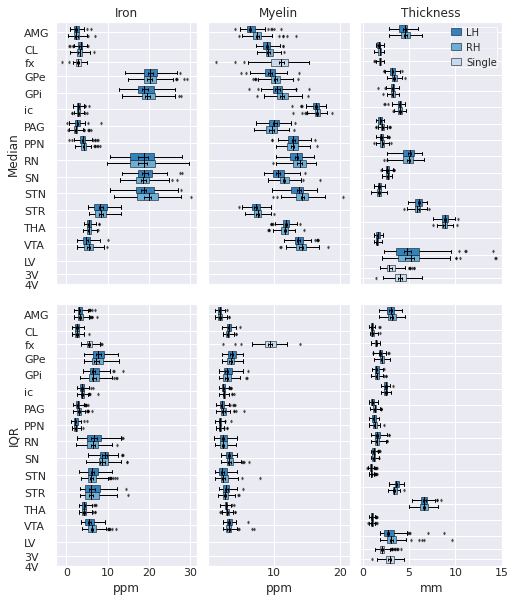

In [87]:
### Error bars
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.26
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.26
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            errbars = np.abs(CIs-medians).loc[ROI,intensity,statistic]
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, bootstrap=1000, 
                                          boxprops={'linewidth':0.5}, positions=[position], 
                                          patch_artist = True, widths=[width], vert=False, zorder=1)
            ax[ax_x, ax_y].errorbar(x=medians.loc[ROI,intensity,statistic], y=position, xerr=errbars[:,np.newaxis], 
                                    linewidth=1, color='black', linestyle='--', capsize=width*3, zorder=2)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
            

        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v6_massp2.pdf', bbox_inches='tight')

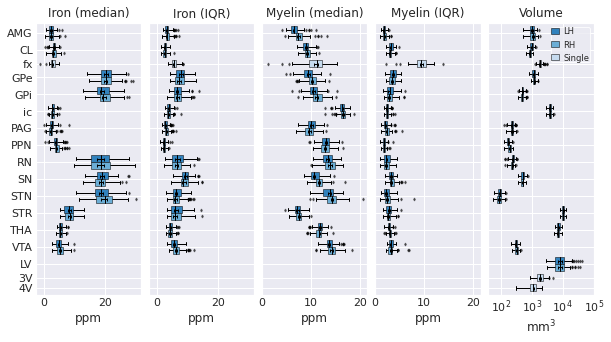

In [88]:
### Error bars
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(1,5, figsize=(10,5), sharey=True, gridspec_kw={'wspace': 0.075, 'hspace': 0.075})
ax = ax[np.newaxis,:]


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'seg']):
    ax_y *= 2
    if intensity == 'seg':
        statistics = ['Volume']
    else:
        statistics = ['Median', 'IQR']
    
    for ax_x, statistic in enumerate(statistics):
        ax_y += ax_x
        ax_x = 0
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.26
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.26
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'seg':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            errbars = np.abs(CIs-medians).loc[ROI,intensity,statistic]
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, bootstrap=1000, 
                                          boxprops={'linewidth':0.5}, positions=[position], 
                                          patch_artist = True, widths=[width], vert=False, zorder=1)
            ax[ax_x, ax_y].errorbar(x=medians.loc[ROI,intensity,statistic], y=position, xerr=errbars[:,np.newaxis], 
                                    linewidth=1, color='black', linestyle='--', capsize=width*3, zorder=2)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
            

        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 4:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
#            ax[ax_x,ax_y].set_ylabel(statistic)
#         if ax_y > 0:
#             ax[ax_x,ax_y].set_yticks(labelpos)
#             ax[ax_x,ax_y].set_yticklabels([])
#        if ax_y == 4:
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-3)
#        else:
#            ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-2)
#         ax[ax_x,ax_y].ticklabel_format(useOffsetbool=False) #axis='both', which='major', pad=-3)

        ax[ax_x,ax_y].invert_yaxis()

        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 0:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm$^3$'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,-1].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='x-small')
# sns.despine()
ax[0,2].set_xlim([0,ax[0,2].get_xlim()[1]])
ax[0,-1].set_xscale('log')
ax[0,-1].set_title('Volume')

ax[0,1].sharex(ax[0,0])
ax[0,3].sharex(ax[0,2])
ax[0,-1].set_xticks([1e2, 1e3, 1e4, 1e5])
#

ax[0,0].set_title('Iron (median)')
ax[0,1].set_title('Iron (IQR)')
ax[0,2].set_title('Myelin (median)')
ax[0,3].set_title('Myelin (IQR)')

# plt.draw()  # this is needed because get_window_extent needs a renderer to work
# yax = ax[0,0].get_yaxis()
# # find the maximum width of the label on the major ticks
# pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
# yax.set_tick_params(pad=pad)

# yax = ax[1,0].get_yaxis()
# # find the maximum width of the label on the major ticks
# pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
# yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v7_massp2_r1.pdf', bbox_inches='tight')

### Correlation between iron median & iqr?

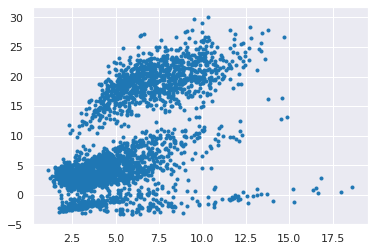

In [57]:
plt.plot(data_long.loc[(data_long.Intensity == 'iron') & (data_long.Statistic == 'IQR'), 'Value'],
         data_long.loc[(data_long.Intensity == 'iron') & (data_long.Statistic == 'Median'), 'Value'], '.')

In [73]:
%load_ext rpy2.ipython
from scipy import stats
import statsmodels

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [59]:
rvals = []
for ROI in data_long.ROI.unique():
    if ROI in ['3V', '4V', 'LV L', 'LV R']:
        continue
    rvals.append(pd.DataFrame({ROI: stats.pearsonr(data_long.loc[(data_long.Intensity == 'iron') & (data_long.Statistic == 'IQR') & (data_long.ROI==ROI), 'Value'],
                                            data_long.loc[(data_long.Intensity == 'iron') & (data_long.Statistic == 'Median') & (data_long.ROI==ROI), 'Value'])}))
correlation_df = pd.concat(rvals, axis=1).T
correlation_df.columns = ['r', 'p']
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(correlation_df['p'], method='fdr_bh')
correlation_df['p.fdr'] = p_fdr
correlation_df['significant'] = correlation_df['p.fdr'] < 0.05
correlation_df.sort_values('r')

,r,p,p.fdr,significant
PAG L,0.094570,3.372507e-01,3.372507e-01,False
CL L,0.114997,2.427492e-01,2.520857e-01,False
CL R,0.206260,3.477325e-02,3.755511e-02,True
PAG R,0.295953,2.174622e-03,2.446450e-03,True
ic R,0.307437,1.421641e-03,1.668883e-03,True
ic L,0.353651,2.149124e-04,2.637561e-04,True
STN R,0.366937,1.180316e-04,1.517549e-04,True
AMG L,0.469370,4.399384e-07,5.939169e-07,True
VTA L,0.483329,1.765269e-07,2.508540e-07,True
fx,0.488291,1.263408e-07,1.895112e-07,True


(0.8269023782994968, 1.0570325907082664e-07)

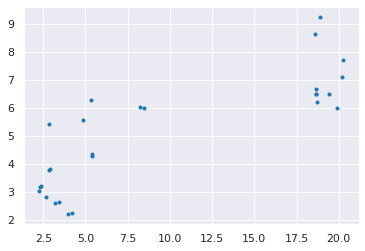

In [60]:
iron_median_iqr = data_long.loc[(data_long.Intensity == 'iron')].groupby(['ROI', 'Statistic']).median().reset_index()
iron_median_iqr = iron_median_iqr.loc[~iron_median_iqr.ROI.isin(['3V', '4V', 'LV L', 'LV R'])]

median_vals = iron_median_iqr.loc[iron_median_iqr.Statistic == "Median", 'Value']
iqr_vals = iron_median_iqr.loc[iron_median_iqr.Statistic == "IQR", 'Value']
plt.plot(median_vals, iqr_vals, '.')
stats.pearsonr(median_vals, iqr_vals)

In [64]:
%%R -i median_vals -i iqr_vals

cor.test(median_vals, iqr_vals)


	Pearson's product-moment correlation

data:  median_vals and iqr_vals
t = 7.3523, df = 25, p-value = 1.057e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6516636 0.9183417
sample estimates:
      cor 
0.8269024 



In [65]:
rvals = []
for ROI in data_long.ROI.unique():
    if ROI in ['3V', '4V', 'LV L', 'LV R']:
        continue
    rvals.append(pd.DataFrame({ROI: stats.pearsonr(data_long.loc[(data_long.Intensity == 'myelin') & (data_long.Statistic == 'IQR') & (data_long.ROI==ROI), 'Value'],
                                                   data_long.loc[(data_long.Intensity == 'myelin') & (data_long.Statistic == 'Median') & (data_long.ROI==ROI), 'Value'])}))
correlation_df = pd.concat(rvals, axis=1).T
correlation_df.columns = ['r', 'p']
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(correlation_df['p'], method='fdr_bh')
correlation_df['p.fdr'] = p_fdr
correlation_df['significant'] = correlation_df['p.fdr'] < 0.05
correlation_df.sort_values('r')

,r,p,p.fdr,significant
PAG R,-0.588418,4.087587e-11,1.103649e-09,True
RN L,-0.557776,6.366026e-10,8.594135e-09,True
GPe R,-0.518438,1.471232e-08,1.324109e-07,True
PAG L,-0.487772,1.308732e-07,8.833941e-07,True
GPi L,-0.442791,2.247029e-06,1.213396e-05,True
RN R,-0.435877,3.359334e-06,1.511700e-05,True
VTA R,-0.418649,8.811950e-06,3.398895e-05,True
GPi R,-0.412730,1.212655e-05,4.092710e-05,True
GPe L,-0.397889,2.631013e-05,7.893040e-05,True
STR R,-0.382525,5.647782e-05,1.524901e-04,True


(-0.048178764391331695, 0.8113874068052921)

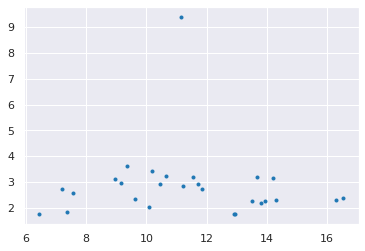

In [72]:
myelin_median_iqr = data_long.loc[(data_long.Intensity == 'myelin')].groupby(['ROI', 'Statistic']).median().reset_index()
myelin_median_iqr = myelin_median_iqr.loc[~myelin_median_iqr.ROI.isin(['3V', '4V', 'LV L', 'LV R'])]

median_vals = myelin_median_iqr.loc[myelin_median_iqr.Statistic == "Median", 'Value']
iqr_vals = myelin_median_iqr.loc[myelin_median_iqr.Statistic == "IQR", 'Value']
plt.plot(median_vals, iqr_vals, '.')
stats.pearsonr(median_vals, iqr_vals)

## Histogram of age distribution

In [98]:
subjects

,Intensity,Measure,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
Segmentation,,,,,,,,,,,
sub-000,iron,IQR_intensity,22.0,f,1408505.6,3V,6.955742,3V,X,GM,IQR
sub-001,iron,IQR_intensity,23.0,m,1564215.2,3V,9.786488,3V,X,GM,IQR
sub-002,iron,IQR_intensity,25.0,f,1102390.1,3V,17.986074,3V,X,GM,IQR
sub-003,iron,IQR_intensity,23.0,f,1216809.8,3V,6.304983,3V,X,GM,IQR
sub-004,iron,IQR_intensity,23.0,f,1374277.9,3V,7.304249,3V,X,GM,IQR
...,...,...,...,...,...,...,...,...,...,...,...
sub-105,iron,IQR_intensity,28.0,f,1257901.9,3V,16.361900,3V,X,GM,IQR
sub-106,iron,IQR_intensity,20.0,m,1449840.9,3V,7.435049,3V,X,GM,IQR
sub-107,iron,IQR_intensity,23.0,m,1401342.5,3V,5.255726,3V,X,GM,IQR


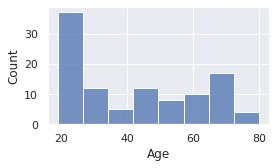

In [113]:
sns.set_context('paper')
sns.set(rc={"figure.figsize":(4, 2.5)})

subjects = data_long.groupby('Segmentation').first()
sns.histplot(data=subjects, x='Age') #, height=3, aspect=1.25) #, hue='Sexe')

plt.gcf().tight_layout()
plt.gcf().savefig('histogram.pdf', bbox_inches='tight')

In [103]:
subjects.loc[subjects.Age <= 30].Age.mean()

22.785714285714285

In [104]:
subjects.loc[subjects.Age >= 70].Age.mean()

72.84615384615384

##### old stuff below

## Early attempts

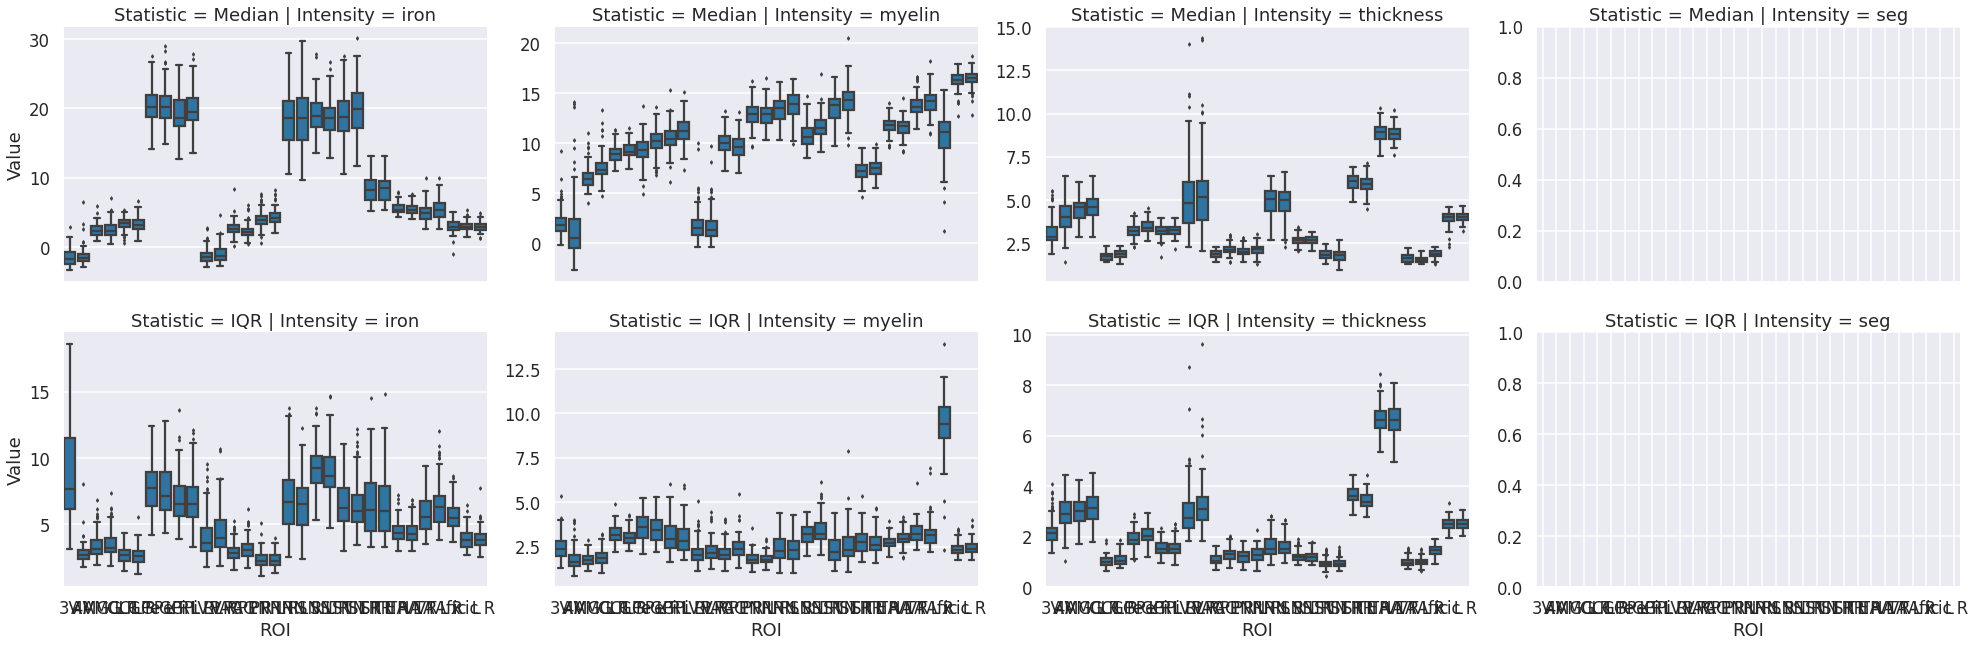

In [9]:
width = 7
aspect = 1.5
sns.set_context('talk')
fac = sns.FacetGrid(data=data_long, col='Intensity', row='Statistic', row_order=['Median', 'IQR'], 
                    sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
# fac.map(plt.axhline, y=0, linestyle='--')
fac.map(sns.boxplot, 'ROI', 'Value', fliersize=2.5, order=data_long['ROI'].unique())

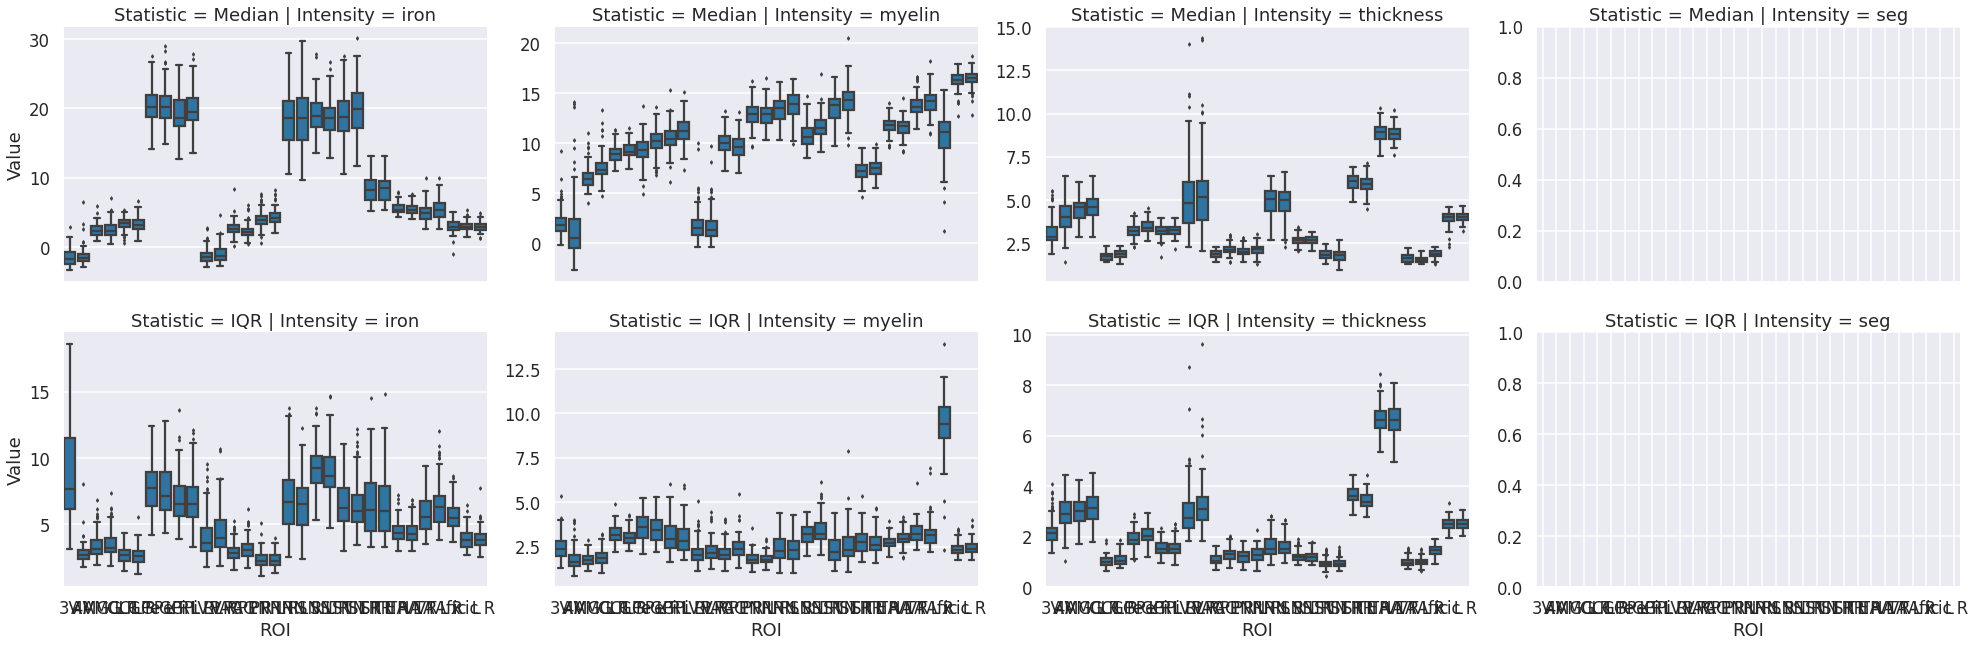

In [10]:
# OLD
width = 7
aspect = 1.5
sns.set_context('talk')
fac = sns.FacetGrid(data=data_long, col='Intensity', row='Statistic', row_order=['Median', 'IQR'], 
                    sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
# fac.map(plt.axhline, y=0, linestyle='--')
fac.map(sns.boxplot, 'ROI', 'Value', fliersize=2.5, order=data_long['ROI'].unique())

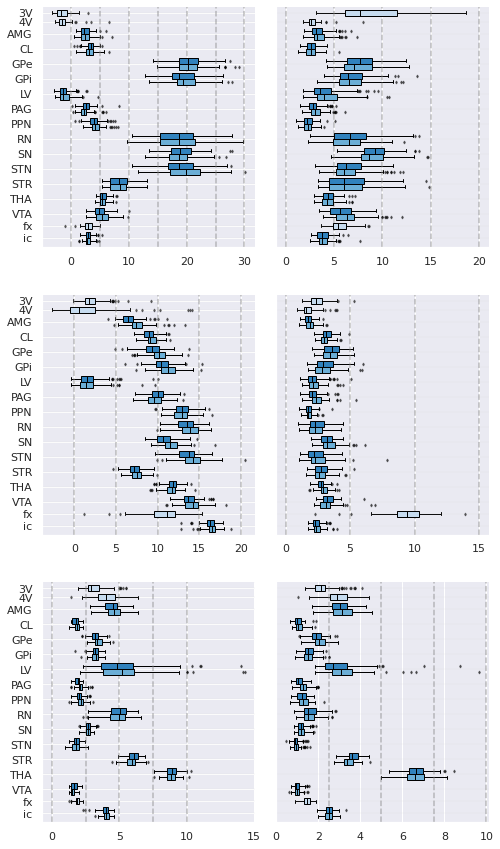

In [11]:
sns.set_context('notebook')
f, ax = plt.subplots(3,2, figsize=(8,15), sharey=False, sharex=False, gridspec_kw={'wspace': 0.1})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5

for ax_n, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_y, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if 'VENT' in ROI and not intensity == 'thickness':
                continue
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
#             bps[intensity][statistic]['f'].append(ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False))

    #         # M
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='m'), 'Value']
    #         bps[intensity][statistic]['m'].append(ax[ax_n].boxplot(values, notch=False, positions=[position+width/2], patch_artist = True, widths=[width/2]))

        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels(labelpos.index)
        if ax_y == 1:
            ax[ax_n,ax_y].set_yticks([])
            ax[ax_n,ax_y].set_yticklabels([])
        _ = [ax[ax_n,ax_y].axhline(x, alpha=0.1, color='lightgrey') for x in labelpos]

        if intensity == 'iron':
            if statistic == 'IQR':
                lines = np.arange(0,21,5)
            else:
                lines = np.arange(0,31,5)
        elif intensity == 'myelin':
            if statistic == 'IQR':
                lines = np.arange(0,16,5)
            else:
                lines = np.arange(0,21,5)
        else:
            lines = np.arange(0,11,2.5)
        
        _ = [ax[ax_n,ax_y].axvline(x, color='grey', linestyle = '--', alpha = 0.5) for x in lines]
        ax[ax_n,ax_y].invert_yaxis()

sns.despine()
# f.savefig('../figures/boxplots_test.pdf', bbox_inches='tight')

## Label in center?

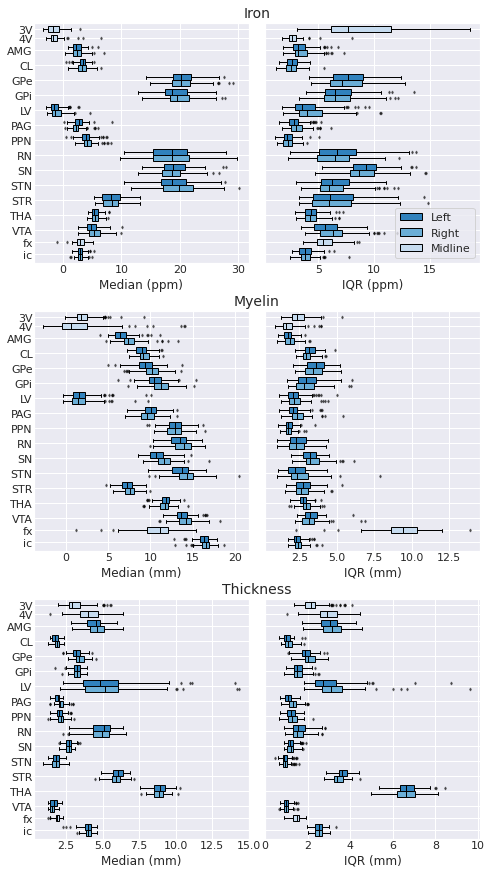

In [12]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(3,2, figsize=(8,15), sharey=False, sharex=False, gridspec_kw={'wspace': 0.075})

cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_n, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_y, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if 'VENT' in ROI and not intensity == 'thickness':
                continue
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels(labelpos.index)
        if ax_y == 1:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels([])
        ax[ax_n,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_n,ax_y].invert_yaxis()
        
        # Axis labels
        unit = 'ppm' if intensity in ['iron', 'median'] else 'mm'
        ax[ax_n, ax_y].set_xlabel('{} ({})'.format(statistic, unit))
        
        # add subplot with title
        if(ax_y == 0):
            ax_ = f.add_subplot(3,1,ax_n+1)
            ax_.axis('off')
            ax_.set_title(intensity.capitalize(), fontdict={'fontsize': 14})

ax[0,1].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], ['Left', 'Right', 'Midline'])
# sns.despine()
# f.savefig('../figures/boxplots_test2.pdf', bbox_inches='tight')

## one final shot at horizontal?


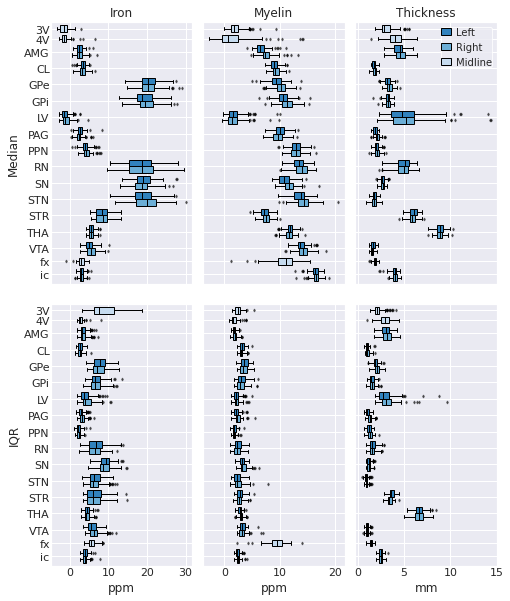

In [13]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if 'VENT' in ROI and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index)
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
        
#         # add subplot with title
#         if(ax_n == 0):
#             ax_ = f.add_subplot(3,1,ax_n+1)
#             ax_.axis('off')
#             ax_.set_title(intensity.capitalize(), fontdict={'fontsize': 14})

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['Left', 'Right', 'Midline'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()

# f.savefig('../figures/figure1_boxplots_v3.pdf', bbox_inches='tight')

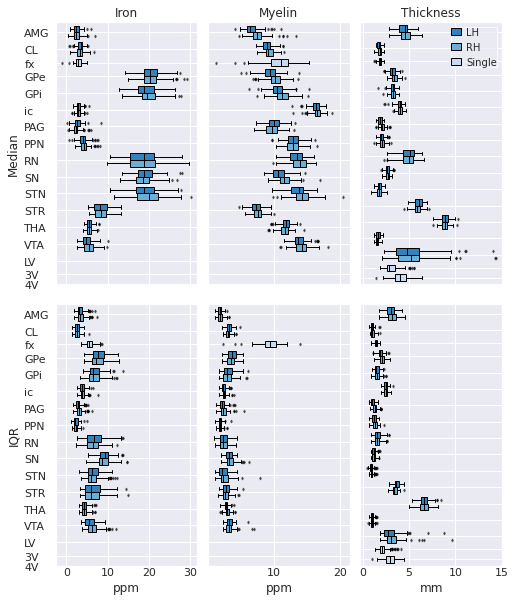

In [14]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v4.pdf', bbox_inches='tight')

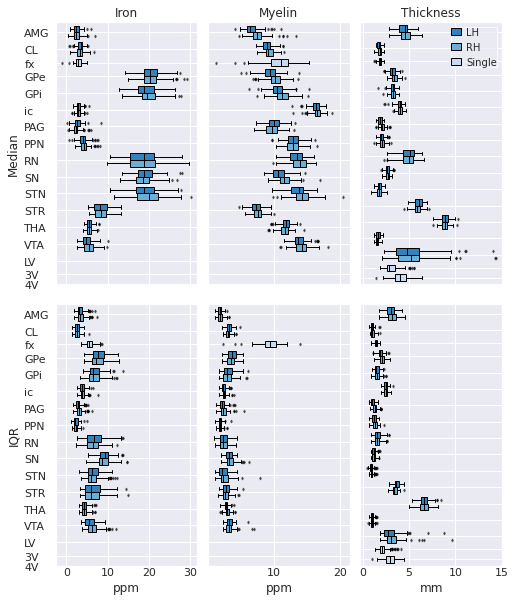

In [15]:
###
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v5.pdf', bbox_inches='tight')

## New table with volumes

In [16]:
demo = pd.read_csv('../data/source_data/ahead_demographics.csv', sep=';')
demo = demo.loc[pd.notnull(demo['ScanName'])]
demo['Segmentation'] = demo['ScanName'].apply(lambda x: 'sub-' + x[-3:])
demo.head()


data = pd.read_csv('../data/source_data/fcm/ahead-31struct-qmri2fcm-final-thickness-statistics.csv')
# data = pd.concat(data)
col_names = ['STR L', 'STR R',
             'STN L', 'STN R',
             'SN L', 'SN R',
             'RN L', 'RN R',
             'GPi L', 'GPi R',
             'GPe L', 'GPe R',
             'THA L', 'THA R',
             'LV L', 'LV R',
             '3V', '4V',
             'AMG L', 'AMG R',
             'ic L', 'ic R',
             'VTA L', 'VTA R',
             'fx',
             'PAG L', 'PAG R',
             'PPN L', 'PPN R',
             'CL L', 'CL R']

data.columns = ['Measure', 'Segmentation', 'Template', 'Intensity'] + col_names
data['Segmentation'] = data['Segmentation'].apply(lambda x: x.split('_')[0])
data = data.loc[data['Segmentation'] != 'sub-070']  # subject was dropped due to data quality issues
del data['Template']

# ICV
icv = pd.read_csv('../data/source_data/ahead-qmr2-icv-statistics.csv')
del icv['Template']
del icv['Intensity']
icv['Segmentation'] = icv['Segmentation'].apply(lambda x: x.split('_')[0])
whole_brain_volume = icv.rename(columns={'Label_1': 'icv'})

# merge subcortex data with demographics
data = pd.merge(data, demo[['Sexe', 'Age', 'Segmentation']], on='Segmentation')
data = data.sort_values(['Measure', 'Segmentation', 'Intensity'])
data.head()

# Merge with volume
data = pd.merge(data, whole_brain_volume.loc[whole_brain_volume.Measure=='Volume',['Segmentation', 'icv']])

# coerce to float
for col in col_names:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data['Intensity'] = 'seg'

structs = []
for col in data.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe', 'icv']:
        continue
    data[col] = data[col].astype(float)
    structs.append(col)

ahead_volumes = data.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe', 'icv'],
                          value_vars=structs, value_name='Value', var_name='ROI')
ahead_volumes['ROI2'] = ahead_volumes['ROI'].str.split(' ').apply(lambda x: x[0])
# ahead_long.loc['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])

ahead_volumes['hemisphere'] = ahead_volumes['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
ahead_volumes['tissue_type'] = ahead_volumes['ROI2'].map({'STR': 'GM',
                                                    'STN': 'GM',
                                                    'SN': 'GM',
                                                    'RN': 'GM',
                                                    'GPi': 'GM',
                                                    'GPe': 'GM',
                                                    'THA': 'GM',
                                                    'LV': 'CSF',
                                                    'AMG': 'GM',
                                                    'ic': 'WM',
                                                    'VTA': 'GM',
                                                    'fx': 'WM',
                                                    'PAG': 'GM',
                                                    'PPN': 'GM',
                                                    'ICO': 'GM',
                                                    'SCO': 'GM',
                                                    'CL': 'GM',
                                                    'Cortex': 'GM',
                                                    'Cerebellum': 'GM'})

ahead_volumes['Statistic'] = ahead_volumes['Measure'].replace({'IQR_intensity': 'iqr', 'Median_intensity': 'median', 'Volume': 'voxels'})

ahead_volumes.head()

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
0,seg,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.882512,STR,L,GM,iqr
1,seg,Median_intensity,sub-000,22.0,f,1408505.6,STR L,5.859861,STR,L,GM,median
2,seg,Volume,sub-000,22.0,f,1408505.6,STR L,10197.734000,STR,L,GM,voxels
3,seg,IQR_intensity,sub-001,23.0,m,1564215.2,STR L,3.578887,STR,L,GM,iqr
4,seg,Median_intensity,sub-001,23.0,m,1564215.2,STR L,6.735042,STR,L,GM,median


In [17]:
data_long = ahead_volumes.copy()

In [18]:
statistic

'IQR'

In [19]:
data_long

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
0,seg,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.882512,STR,L,GM,iqr
1,seg,Median_intensity,sub-000,22.0,f,1408505.6,STR L,5.859861,STR,L,GM,median
2,seg,Volume,sub-000,22.0,f,1408505.6,STR L,10197.734000,STR,L,GM,voxels
3,seg,IQR_intensity,sub-001,23.0,m,1564215.2,STR L,3.578887,STR,L,GM,iqr
4,seg,Median_intensity,sub-001,23.0,m,1564215.2,STR L,6.735042,STR,L,GM,median
...,...,...,...,...,...,...,...,...,...,...,...,...
9760,seg,Median_intensity,sub-108,23.0,m,1294834.0,CL R,2.159126,CL,R,GM,median
9761,seg,Volume,sub-108,23.0,m,1294834.0,CL R,868.027040,CL,R,GM,voxels
9762,seg,IQR_intensity,sub-109,23.0,f,1363826.2,CL R,1.399997,CL,R,GM,iqr
9763,seg,Median_intensity,sub-109,23.0,f,1363826.2,CL R,2.304476,CL,R,GM,median


In [20]:
ax_y

2

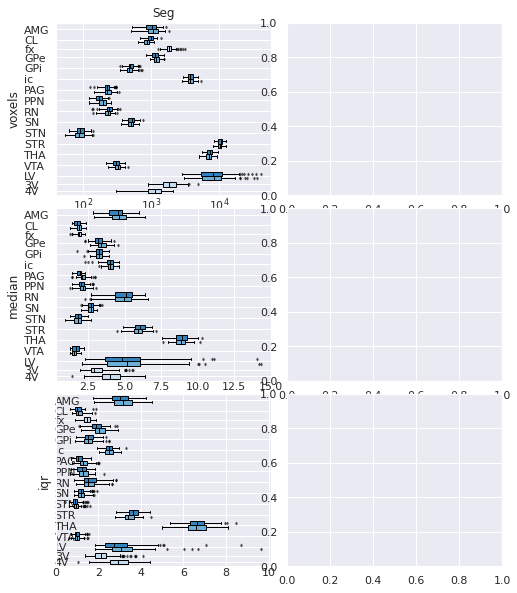

In [21]:
###
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(3,2, figsize=(8,10), sharey=False, sharex=False, gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['seg']):
    for ax_x, statistic in enumerate(['voxels', 'median', 'iqr']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
#             if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
#                 continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

# ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
#                ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
#                labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


ax[0,0].set_xscale('log')

plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

# f.savefig('../figures/figure1_boxplots_v5.pdf', bbox_inches='tight')

## For reviewer 1: Compare iron, myelin values obtained from data with literature

In [212]:
data_median = data_long_with_cortex.loc[(data_long_with_cortex['Measure'] == 'Median_intensity') & (data_long_with_cortex['Intensity'].isin(['iron', 'myelin']))]  # get median within region
data_median = data_median.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI', 'ROI2', 'Age'])

In [213]:
data_p30_means = data_median.query('Age >= 30').groupby(level=[0, 2]).mean().groupby(level=[1]).mean()  # get mean of medians
data_p30_sds = data_median.query('Age >= 30').groupby(level=[0, 2]).mean().groupby(level=[1]).std()     # get std of medians
data_p30 = pd.concat([data_p30_means, data_p30_sds], axis=1)

# For comparison with the literature, we compare STR with CAU and PUT; (frontal) white matter with ic, and various cortical gray with cruise-derived cortes
data_p30.loc['CAU'] = data_p30.loc['STR']
data_p30.loc['PUT'] = data_p30.loc['STR']
data_p30.loc['Frontal Cortex'] = data_p30.loc['Cortex']
data_p30.loc['Temporal Cortex'] = data_p30.loc['Cortex']
data_p30.loc['Parietal Cortex'] = data_p30.loc['Cortex']
data_p30.loc['Sensory Cortex'] = data_p30.loc['Cortex']
data_p30.loc['Occipital Cortex'] = data_p30.loc['Cortex']
data_p30.loc['Motor Cortex'] = data_p30.loc['Cortex']
data_p30.loc['Frontal White'] = data_p30.loc['ic']

# Split into iron and myelin
data_p30_iron = data_p30.iloc[:,[0,2]]
data_p30_iron.columns = ['mean', 'sd']
data_p30_myelin = data_p30.iloc[:,[1,3]]
data_p30_myelin.columns = ['mean', 'sd']

### Literature values

In [340]:
## From Hallgren, 1958
literature_iron_mean = pd.Series({'RN': 19.48,
                           'SN': 18.46,
                           'GPi': 21.30,
                           'GPe': 21.30,
                           'THA': 4.76,
                           'PUT': 13.32,
                           'CAU': 9.28,
                           'Cerebellum': 3.35,
                           'Frontal Cortex': 2.92,
                           'Temporal Cortex': 3.13,
                           'Parietal Cortex': 3.81,
                           'Sensory Cortex': 4.32,
                           'Occipital Cortex': 4.55,
                           'Motor Cortex': 5.03,
                           'LV': 0.061,      # CSF measures NOT from Hallgren, but from Metere et al. (2018) / LeVine et al 1998
                           'Frontal White': 4.24,
                           'Brainstem': 1.40}, name='iron')
literature_iron_sd = pd.Series({'RN': 6.86,
                           'SN': 6.52,
                           'GPi': 3.49,
                           'GPe': 3.49,
                           'THA': 1.16,
                           'PUT': 3.43,
                           'CAU': 2.14,
                           'Cerebellum': 0.87,
                           'Frontal Cortex': 0.41,
                           'Temporal Cortex': 0.57,
                           'Parietal Cortex': 0.67,
                           'Sensory Cortex': 0.58,
                           'Occipital Cortex': 0.67,
                           'Motor Cortex': 0.88,
                           'LV': 0.018,      # CSF measures NOT from Hallgren, but from Metere et al. (2018) / LeVine et al 1998
                           'Frontal White': 0.88,
                           'Brainstem': 1.16}, name='iron')

literature_iron = pd.concat([literature_iron_mean, literature_iron_sd], axis=1)
literature_iron.columns = ['mean', 'sd']
literature_iron


## From Randall, 1938
literature_myelin_mean = pd.Series({'CAU': 6.21,
                             'LV': 0.0025,   # CSF meaures NOT from Randall, but from Metere et al. (2018)
                             'Frontal Cortex': 5.08,
                             'Parietal Cortex': 5.42,
                             'THA': 11.40,
                             'Frontal White': 16.26,
                             'Parietal White': 17.20,
                             'Brainstem': 15.36}, name='myelin')
literature_myelin_sd = pd.Series({'CAU': 2.43,
                             'LV': 0.00,   # CSF meaures NOT from Randall, but from Metere et al. (2018) - no SD reported in the original study
                             'Frontal Cortex': 1.48,
                             'Parietal Cortex': 1.15,
                             'THA': 1.93,
                             'Frontal White': 2.48,
                             'Parietal White': 1.68,
                             'Brainstem': 1.58}, name='myelin')

literature_myelin = pd.concat([literature_myelin_mean, literature_myelin_sd], axis=1)
literature_myelin.columns = ['mean', 'sd']
literature_myelin

,mean,sd
CAU,6.2100,2.43
LV,0.0025,0.00
Frontal Cortex,5.0800,1.48
Parietal Cortex,5.4200,1.15
THA,11.4000,1.93
Frontal White,16.2600,2.48
Parietal White,17.2000,1.68
Brainstem,15.3600,1.58


#### Myelin estimates from stain (no sd)

In [341]:
stain_myelin = pd.read_pickle('./all_myelin_estimates.pkl')
stain_myelin = stain_myelin.loc[pd.isnull(stain_myelin.myelin), 'predicted_myelin']
stain_myelin

Randall_label
GP     10.404170
PUT     5.611496
RN     13.441928
SN      7.404243
STN    14.423179
GPe    10.404170
GPi    10.404170
Name: predicted_myelin, dtype: float64

### Combine data sources

In [342]:
myelin_combined = pd.merge(data_p30_myelin, literature_myelin, left_index=True, right_index=True, suffixes=('_data', '_literature'))
iron_combined = pd.merge(data_p30_iron, literature_iron, left_index=True, right_index=True, suffixes=('_data', '_literature'))

myelin_stain_combined = pd.merge(data_p30_myelin, stain_myelin, left_index=True, right_index=True, suffixes=('_data', '_literature'))
myelin_stain_combined.columns = ['mean_data', 'sd_data', 'mean_literature']
myelin_stain_combined['sd_literature'] = 0

myelin_stain_combined['source'] = 'stain'
myelin_combined['source'] = 'literature'
myelin_combined = pd.concat([myelin_combined, myelin_stain_combined])

### Pyplot

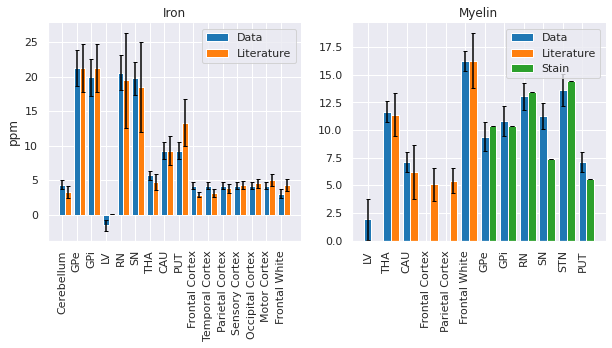

In [343]:
import numpy as np
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,2, figsize=(10,4))#, gridspec_kw={'width_ratios': [0.5, .1, 0.25, .25], 'wspace': 0})
colors = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2]]

# set width of bars
barWidth = 0.4

# First iron
bars1 = iron_combined['mean_data']        ## data
bars2 = iron_combined['mean_literature']  ## literature

# Set position of bar on X axis
r1 = np.arange(len(bars1)) - barWidth/2
r2 = [x + barWidth for x in r1]

ax[0].bar(r1, bars1, color=colors[0], width=barWidth, edgecolor='white', label='Data')
ax[0].errorbar(x = r1, y = bars1, yerr=iron_combined['sd_data'], fmt='none', c= 'black', capsize = 2)
ax[0].bar(r2, bars2, color=colors[1], width=barWidth, edgecolor='white', label='Literature')
ax[0].errorbar(x = r2, y = bars2, yerr=iron_combined['sd_literature'], fmt='none', c= 'black', capsize = 2)
ax[0].set_xticks(r1)
ax[0].set_xticklabels(iron_combined.index, rotation=90)


# Myelin from literature
bars1= myelin_combined['mean_data']  ## all data points
r1 = np.arange(len(bars1)) - barWidth/2
ax[1].bar(r1, bars1, color=colors[0], width=barWidth, edgecolor='white', label='Data')
ax[1].errorbar(x = r1, y = bars1, yerr=myelin_combined['sd_data'], fmt='none', c= 'black', capsize = 2)

# Literature / stain
bars2= myelin_combined['mean_literature']  ## all data points
r2 = [x + barWidth for x in r1]

# lit
bars2_lit = [x for i,x in enumerate(bars2) if myelin_combined.iloc[i, -1] == 'literature']
r2_lit = [x for i,x in enumerate(r2) if myelin_combined.iloc[i, -1] == 'literature']
yerrs = myelin_combined.loc[myelin_combined['source']=='literature','sd_literature']

ax[1].bar(r2_lit, bars2_lit, color=colors[1], width=barWidth, edgecolor='white', label='Literature')
ax[1].errorbar(x = r2_lit, y = bars2_lit, yerr=yerrs, fmt='none', c= 'black', capsize = 2)

# stain
bars2_stain = [x for i,x in enumerate(bars2) if myelin_combined.iloc[i, -1] == 'stain']
r2_stain = [x for i,x in enumerate(r2) if myelin_combined.iloc[i, -1] == 'stain']
yerrs = myelin_combined.loc[myelin_combined['source']=='stain','sd_literature']

ax[1].bar(r2_stain, bars2_stain, color=colors[2], width=barWidth, edgecolor='white', label='Stain')
ax[1].errorbar(x = r2_stain, y = bars2_stain, yerr=yerrs, fmt='none', c= 'black', capsize = 2)


###
ax[0].set_title('Iron')
ax[1].set_title('Myelin')
ax[0].set_ylabel('ppm')
ax[1].set_xticks(r1)
ax[1].set_xticklabels(myelin_combined.index, rotation=90)

# Create legend
ax[0].legend()
ax[1].legend()
sns.despine()

f.savefig('./histogram_iron_myelin.pdf', bbox_inches='tight')

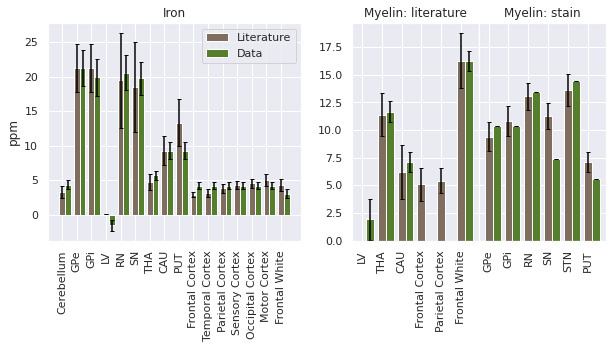

In [264]:
# import numpy as np
# import matplotlib.pyplot as plt

# f, ax = plt.subplots(1,4, figsize=(10,4), gridspec_kw={'width_ratios': [0.5, .1, 0.25, .25], 'wspace': 0})

# # set width of bars
# barWidth = 0.4

# for i in range(4):
#     if i == 0:
#         dtype = 'Iron'
#         tmp = iron_combined
#     elif i == 1:
#         continue
#     elif i == 2:
#         dtype = 'Myelin: Literature'
#         tmp = myelin_combined
#     elif i == 3:
#         dtype = 'Myelin: Stain'
#         tmp = myelin_stain_combined

#     # set heights of bars
#     bars1 = tmp['mean_literature']  ## literature
#     bars2 = tmp['mean_data']        ## data

#     # Set position of bar on X axis
#     r1 = np.arange(len(bars1)) - .2
#     r2 = [x + barWidth for x in r1]

#     # Bar plot
#     ax[i].bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Literature')
#     ax[i].bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Data')

#     # Error bars
#     ax[i].errorbar(x = r1, y = bars1,
#                    yerr=tmp['sd_literature'], fmt='none', c= 'black', capsize = 2)
#     ax[i].errorbar(x = r2, y = bars2,
#                    yerr=tmp['sd_data'], fmt='none', c= 'black', capsize = 2)

#     ax[i].set_title(dtype.capitalize())
#     ax[i].set_xticks(r1)
#     ax[i].set_xticklabels(tmp.index, rotation=90)

# ax[-1].set_ylim(ax[-2].get_ylim())
# ax[-1].set_yticklabels([])
# ax[1].axis('off')
# ax[0].set_ylabel('ppm')

# # Create legend
# ax[0].legend()